In [85]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import QuantileTransformer

import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [86]:
df =pd.read_pickle('../pickle_pd/second_pd_top_25.pkl')
features = list(df)[:-1]
qt = QuantileTransformer(random_state=0)
df[features] = qt.fit_transform(df[features])
y = df.pop('label')
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = tf.keras.utils.to_categorical(y_encoded)

In [87]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], y_one_hot, test_size=0.4, random_state=42,shuffle = True)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42,shuffle = True)

In [88]:
space={#'dimension': hp.uniform("dimension", 64, 256),
        'learning_rate': hp.uniform ('learning_rate', 0.0005,0.005),
        'beta_1' : hp.uniform('beta_1', 0.5,0.99),
        'beta_2' : hp.uniform('beta_2', 0.8,0.9999),
        'epsilon' : hp.uniform('epsilon', 1e-08,1e-06),
        'dropout' : hp.uniform('dropout', 0,0.5),
        'size_l_1' : hp.choice('size_l_1',[64, 128, 256]),
        'size_l_2' : hp.choice('size_l_2',[32, 64, 128]),
        'size_l_3' : hp.choice('size_l_3',[16, 32, 64]),
        'extra_lay': hp.choice('extra_lay',[0, 1 ,2])
        
    }

In [118]:
def objective(space):
    optimizer = Adam(learning_rate=space['learning_rate'],
                     beta_1=space['beta_1'], beta_2=space['beta_2'],
                     epsilon=space['epsilon'],
                     ema_momentum=space['ema_momentum'])
                
    model = Sequential()
    
    model.add(Dense(space['size_l_1'], activation='relu', input_dim=25))
    model.add(Dropout(space['dropout']))
    model.add(Dense(space['size_l_2'], activation='relu'))
    model.add(Dense(space['size_l_3'], activation='relu'))
    
    if space['extra_lay'] == 1:
        model.add(Dense(16, activation='relu'))
    elif space['extra_lay'] == 2:
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
    
    model.add(Dense(3, activation='softmax'))

    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    #model.fit(X_train, y_train,
    #        eval_set=evaluation, #eval_metric="auc",
    #        early_stopping_rounds=10,verbose=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    fit_results = model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=150,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )
    
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    pred = model.predict(X_train)
    accuracy = accuracy_score(y_train_labels, np.argmax(pred, axis = 1))
    pred_val = model.predict(X_test)
    val_accuracy = accuracy_score(y_test_labels, np.argmax(pred_val, axis = 1))
    delta_accuracy = accuracy - val_accuracy
    print ("SCORE:", accuracy)
    return {'loss': -val_accuracy, 'accuracy': accuracy, 'val_accuracy': val_accuracy, 'delta_accuracy':delta_accuracy, 'status': STATUS_OK }

In [119]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|                                              | 0/50 [00:00<?, ?trial/s, best loss=?]

9764/9764 [==============================] - 2s 219us/step                               

3255/3255 [==============================] - 1s 216us/step                               

SCORE:                                                                                    
0.8648498990151173                                                                        
  2%|▎                | 1/50 [01:31<1:15:02, 91.88s/trial, best loss: -0.8641265207747189]

9764/9764 [==============================] - 2s 237us/step                               

3255/3255 [==============================] - 1s 228us/step                               

SCORE:                                                                                    
0.8766864155327873                                                                        
  4%|▋               | 2/50 [03:39<1:30:15, 112.83s/trial, best loss: -0.8674201323206038]

4109/9764 [===========>..................] - ETA: 6s                                     


5998/9764 [=================>............] - ETA: 6s                                     


8416/9764 [========================>.....] - ETA: 2s                                     


9764/9764 [==============================] - 18s 2ms/step                                

 908/3255 [=======>......................] - ETA: 3s                                     


3255/3255 [==============================] - 5s 2ms/step                                 

SCORE:                                                                                    
0.744106547853391                                                                         
  6%|▉               | 3/50 [09:50<3:00:42, 230.69s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 2s 231us/step                               

3255/3255 [==============================] - 1s 226us/step                               

SCORE:                                                                                    
0.8677946245955004                                                                        
  8%|█▎              | 4/50 [12:00<2:26:31, 191.11s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 4s 362us/step                               

2853/3255 [=========================>....] - ETA: 0s                                     


3255/3255 [==============================] - 1s 297us/step                               

SCORE:                                                                                    
0.8875242859840665                                                                        
 10%|█▌              | 5/50 [14:40<2:14:50, 179.78s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 3s 315us/step                               

3255/3255 [==============================] - 1s 290us/step                               

SCORE:                                                                                    
0.8467142303863672                                                                        
 12%|█▉              | 6/50 [16:55<2:00:33, 164.40s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 2s 243us/step                               

3255/3255 [==============================] - 1s 230us/step                               

SCORE:                                                                                    
0.8729062841084043                                                                        
 14%|██▏             | 7/50 [19:06<1:50:08, 153.68s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 3s 301us/step                               

3255/3255 [==============================] - 1s 288us/step                               

SCORE:                                                                                    
0.8606600666404202                                                                        
 16%|██▌             | 8/50 [23:20<2:09:48, 185.44s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 3s 280us/step                               

3255/3255 [==============================] - 1s 366us/step                               

SCORE:                                                                                    
0.8656084859309334                                                                        
 18%|██▉             | 9/50 [26:03<2:01:59, 178.52s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 3s 309us/step                               

3255/3255 [==============================] - 1s 279us/step                               

SCORE:                                                                                    
0.8669240100760828                                                                        
 20%|███            | 10/50 [29:49<2:08:48, 193.22s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 3s 332us/step                               

3255/3255 [==============================] - 1s 300us/step                               

SCORE:                                                                                    
0.8614026496128646                                                                        
 22%|███▎           | 11/50 [33:05<2:06:06, 194.01s/trial, best loss: -0.8674201323206038]

9764/9764 [==============================] - 3s 306us/step                               

3255/3255 [==============================] - 1s 269us/step                               

SCORE:                                                                                    
0.8727942565048028                                                                        
 24%|███▌           | 12/50 [35:54<1:58:09, 186.57s/trial, best loss: -0.8693886173553164]

9764/9764 [==============================] - 3s 320us/step                               

3255/3255 [==============================] - 1s 291us/step                               

SCORE:                                                                                    
0.8701824129465501                                                                        
 26%|███▉           | 13/50 [39:13<1:57:13, 190.10s/trial, best loss: -0.8693886173553164]

9764/9764 [==============================] - 3s 256us/step                               

3255/3255 [==============================] - 1s 244us/step                               

SCORE:                                                                                    
0.8622412562455389                                                                        
 28%|████▏          | 14/50 [40:55<1:38:10, 163.62s/trial, best loss: -0.8693886173553164]

9764/9764 [==============================] - 4s 410us/step                               

1316/3255 [===========>..................] - ETA: 0s                                     


3255/3255 [==============================] - 1s 317us/step                               

SCORE:                                                                                    
0.867023234524987                                                                         
 30%|████▌          | 15/50 [45:06<1:50:51, 190.03s/trial, best loss: -0.8693886173553164]

9764/9764 [==============================] - 3s 277us/step                               

3255/3255 [==============================] - 1s 251us/step                               

SCORE:                                                                                    
0.8639216702995618                                                                        
 32%|████▊          | 16/50 [47:31<1:39:53, 176.29s/trial, best loss: -0.8693886173553164]

9764/9764 [==============================] - 3s 341us/step                               

3255/3255 [==============================] - 1s 312us/step                               



SCORE:                                                                                    
0.8783444240660899                                                                        
 34%|█████          | 17/50 [51:17<1:45:19, 191.49s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 320us/step                               

3255/3255 [==============================] - 1s 286us/step                               

SCORE:                                                                                    
0.8740585680311629                                                                        
 36%|█████▍         | 18/50 [54:26<1:41:36, 190.52s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 275us/step                               

3255/3255 [==============================] - 1s 266us/step                               

SCORE:                                                                                    
0.8692925936950865                                                                        
 38%|█████▋         | 19/50 [56:57<1:32:21, 178.77s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 309us/step                               

3255/3255 [==============================] - 1s 279us/step                               

SCORE:                                                                                    
0.8236301424671039                                                                        
 40%|██████         | 20/50 [59:16<1:23:21, 166.70s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 4s 396us/step                               

1489/3255 [============>.................] - ETA: 0s                                     


3255/3255 [==============================] - 1s 369us/step                               

SCORE:                                                                                    
0.8849476511012313                                                                        
 42%|█████▍       | 21/50 [1:03:41<1:34:50, 196.24s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 4s 374us/step                               

2113/3255 [==================>...........] - ETA: 0s                                     


3255/3255 [==============================] - 1s 360us/step                               

SCORE:                                                                                    
0.8875915025462274                                                                        
 44%|█████▋       | 22/50 [1:08:10<1:41:51, 218.27s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 320us/step                               

3255/3255 [==============================] - 1s 283us/step                               

SCORE:                                                                                    
0.8719428467174312                                                                        
 46%|█████▉       | 23/50 [1:11:17<1:33:56, 208.76s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 4s 355us/step                               

2766/3255 [========================>.....] - ETA: 0s                                     


3255/3255 [==============================] - 1s 330us/step                               

SCORE:                                                                                    
0.8828095242667794                                                                        
 48%|██████▏      | 24/50 [1:16:11<1:41:31, 234.30s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 315us/step                               

3255/3255 [==============================] - 1s 339us/step                               

SCORE:                                                                                    
0.8750060014787644                                                                        
 50%|██████▌      | 25/50 [1:20:28<1:40:30, 241.21s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 353us/step                               

3227/3255 [============================>.] - ETA: 0s                                     


3255/3255 [==============================] - 1s 296us/step                               

SCORE:                                                                                    
0.8623148743850485                                                                        
 52%|██████▊      | 26/50 [1:25:22<1:42:46, 256.92s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 286us/step                               

3255/3255 [==============================] - 1s 259us/step                               

SCORE:                                                                                    
0.8674297346866268                                                                        
 54%|███████      | 27/50 [1:28:22<1:29:37, 233.79s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 304us/step                               

3255/3255 [==============================] - 1s 295us/step                               

SCORE:                                                                                    
0.8331972998146744                                                                        
 56%|███████▎     | 28/50 [1:30:58<1:17:14, 210.64s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 5s 462us/step                               



3255/3255 [==============================] - 2s 471us/step                               

SCORE:                                                                                    
0.8862503720916833                                                                        
 58%|███████▌     | 29/50 [1:35:01<1:17:05, 220.28s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 237us/step                               

3255/3255 [==============================] - 1s 225us/step                               

SCORE:                                                                                    
0.8490316013865816                                                                        
 60%|███████▊     | 30/50 [1:36:56<1:02:51, 188.56s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 286us/step                               

3255/3255 [==============================] - 1s 254us/step                               

SCORE:                                                                                    
0.8662038326243586                                                                        
 62%|█████████▎     | 31/50 [1:40:01<59:22, 187.51s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 348us/step                               

2986/3255 [==========================>...] - ETA: 0s                                     


3255/3255 [==============================] - 1s 337us/step                               

SCORE:                                                                                    
0.8725029847354389                                                                        
 64%|████████▎    | 32/50 [1:44:14<1:02:08, 207.16s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 260us/step                               

3255/3255 [==============================] - 1s 237us/step                               

SCORE:                                                                                    
0.8663542696920521                                                                        
 66%|█████████▉     | 33/50 [1:47:37<58:23, 206.10s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 296us/step                               

3255/3255 [==============================] - 1s 240us/step                               

SCORE:                                                                                    
0.8684091760209716                                                                        
 68%|██████████▏    | 34/50 [1:49:25<47:06, 176.63s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 273us/step                               

3255/3255 [==============================] - 1s 257us/step                               

SCORE:                                                                                    
0.8897680388447714                                                                        
 70%|██████████▌    | 35/50 [1:53:34<49:36, 198.43s/trial, best loss: -0.8704256728857991]

3745/9764 [==========>...................] - ETA: 7s                                     


9764/9764 [==============================] - 9s 875us/step                               

 622/3255 [====>.........................] - ETA: 1s                                     


3255/3255 [==============================] - 2s 730us/step                               

SCORE:                                                                                    
0.8620140002496616                                                                        
 72%|██████████▊    | 36/50 [1:59:10<55:55, 239.65s/trial, best loss: -0.8704256728857991]

3022/9764 [========>.....................] - ETA: 10s                                     


6054/9764 [=================>............] - ETA: 5s                                     


9366/9764 [===========================>..] - ETA: 0s                                     


9764/9764 [==============================] - 14s 1ms/step                                

2949/3255 [==========================>...] - ETA: 0s                                     


3255/3255 [==============================] - 4s 1ms/step                                 

SCORE:                                                                                    
0.8938106349404493                                                                        
 74%|█████████▌   | 37/50 [2:09:26<1:16:22, 352.52s/trial, best loss: -0.8704256728857991]

7295/9764 [=====================>........] - ETA: 1s                                     


9764/9764 [==============================] - 6s 613us/step                               

3255/3255 [==============================] - 2s 607us/step                               

SCORE:                                                                                    
0.8671896755360521                                                                        
 76%|█████████▉   | 38/50 [2:16:59<1:16:32, 382.69s/trial, best loss: -0.8704256728857991]

6309/9764 [==================>...........] - ETA: 2s                                     


9764/9764 [==============================] - 7s 711us/step                               

3052/3255 [===========================>..] - ETA: 0s                                     


3255/3255 [==============================] - 2s 680us/step                               

SCORE:                                                                                    
0.8674745457280674                                                                        
 78%|██████████▏  | 39/50 [2:23:21<1:10:07, 382.53s/trial, best loss: -0.8704256728857991]

6512/9764 [===================>..........] - ETA: 2s                                     


9764/9764 [==============================] - 7s 683us/step                               

3255/3255 [==============================] - 2s 671us/step                               

SCORE:                                                                                    


0.8022872835866758                                                                        
 80%|██████████▍  | 40/50 [2:29:02<1:01:40, 370.01s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 3s 352us/step                 

3255/3255 [==============================] - 1s 355us/step                 

SCORE:                                                                      
0.8610473620700141                                                          
 82%|▊| 41/50 [2:32:58<49:28, 329.78s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 4s 431us/step                 

3255/3255 [==============================] - 1s 361us/step                 

SCORE:                                                                      
0.8739593435822587                                                          
 84%|▊| 42/50 [2:36:35<39:28, 296.04s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 238us/step                 

3255/3255 [==============================] - 1s 238us/step                 

SCORE:                                                                      
0.8644145917554086                                                          
 86%|▊| 43/50 [2:39:59<31:17, 268.16s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 213us/step                 

3255/3255 [==============================] - 1s 214us/step                 

SCORE:                                                                      
0.8717475986082971                                                          
 88%|▉| 44/50 [2:42:14<22:49, 228.21s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 202us/step                 

3255/3255 [==============================] - 1s 203us/step                 

SCORE:                                                                      
0.857596911879087                                                           
 90%|▉| 45/50 [2:43:51<15:44, 188.89s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 200us/step                 

3255/3255 [==============================] - 1s 200us/step                 

SCORE:                                                                      
0.8621260278532631                                                          
 92%|▉| 46/50 [2:45:26<10:43, 160.96s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 253us/step                 

3255/3255 [==============================] - 1s 253us/step                 

SCORE:                                                                      
0.8671384629172628                                                          
 94%|▉| 47/50 [2:48:18<08:12, 164.29s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 209us/step                 

3255/3255 [==============================] - 1s 210us/step                 

SCORE:                                                                      
0.8665495178011862                                                          
 96%|▉| 48/50 [2:50:22<05:03, 151.91s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 251us/step                 

3255/3255 [==============================] - 1s 248us/step                 

SCORE:                                                                      
0.8784020382622278                                                          
 98%|▉| 49/50 [2:53:04<02:35, 155.16s/trial, best loss: -0.8704256728857991]

9764/9764 [==============================] - 2s 209us/step                 

3255/3255 [==============================] - 1s 212us/step                 

SCORE:                                                                      
0.8752236551086188                                                          
100%|█| 50/50 [2:54:57<00:00, 209.95s/trial, best loss: -0.8704256728857991]


In [120]:
trials.trials[0]

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': -0.8641265207747189,
  'accuracy': 0.8648498990151173,
  'val_accuracy': 0.8641265207747189,
  'delta_accuracy': 0.0007233782403984756,
  'status': 'ok'},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'beta_1': [0],
   'beta_2': [0],
   'dropout': [0],
   'ema_momentum': [0],
   'epsilon': [0],
   'extra_lay': [0],
   'learning_rate': [0],
   'size_l_1': [0],
   'size_l_2': [0],
   'size_l_3': [0]},
  'vals': {'beta_1': [0.7110271192967015],
   'beta_2': [0.8421355411711708],
   'dropout': [0.17247599864649388],
   'ema_momentum': [0.9760393630311767],
   'epsilon': [1.259198263462027e-07],
   'extra_lay': [0],
   'learning_rate': [0.000896522672792109],
   'size_l_1': [0],
   'size_l_2': [1],
   'size_l_3': [1]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2023, 7, 30, 13, 10, 43, 747000),
 'refresh_time': datetime.datetime(2023, 7, 30

In [121]:
trial_res = pd.DataFrame()
for keys in trials.trials[0]['misc']['vals'].keys():
    trial_res[keys] = pd.Series([trial['misc']['vals'][keys] for trial in trials.trials])
trial_res = trial_res.apply(pd.Series.squeeze)
trial_res['train_accuracy'] = [trial['result']['accuracy'] for trial in trials.trials]
trial_res['val_accuracy'] = [trial['result']['val_accuracy'] for trial in trials.trials]
trial_res['delta_accuracy'] = [trial['result']['delta_accuracy'] for trial in trials.trials]
col_names = list(trial_res)
trial_res = pd.concat((pd.DataFrame(trial_res[col].tolist()) for col in list(trial_res)), axis=1)
trial_res.columns = col_names
trial_res['Selection'] = np.zeros(len(trial_res))
trial_res['Selection'][trials.best_trial['tid']] = "best"
#trial_res['size_l_1'][trial_res['size_l_1']== 0] = 64
for i, n in zip([0,1,2], [64, 128, 256]):
    trial_res['size_l_1'][trial_res['size_l_1']== i] = n
for i, n in zip([0,1,2], [32, 64, 128]):
    trial_res['size_l_2'][trial_res['size_l_2']== i] = n
for i, n in zip([0,1,2], [16, 32, 64]):
    trial_res['size_l_3'][trial_res['size_l_3']== i] = n

/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_54629/2544370063.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_res['Selection'][trials.best_trial['tid']] = "best"
/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_54629/2544370063.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_res['size_l_1'][trial_res['size_l_1']== i] = n
/var/folders/jg/_qgpsg4n22d16c3lpjt2qdk80000gn/T/ipykernel_54629/2544370063.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [37]:
list(trial_res)[0:10]

['beta_1',
 'beta_2',
 'dropout',
 'ema_momentum',
 'epsilon',
 'extra_lay',
 'learning_rate',
 'size_l_1',
 'size_l_2',
 'size_l_3']

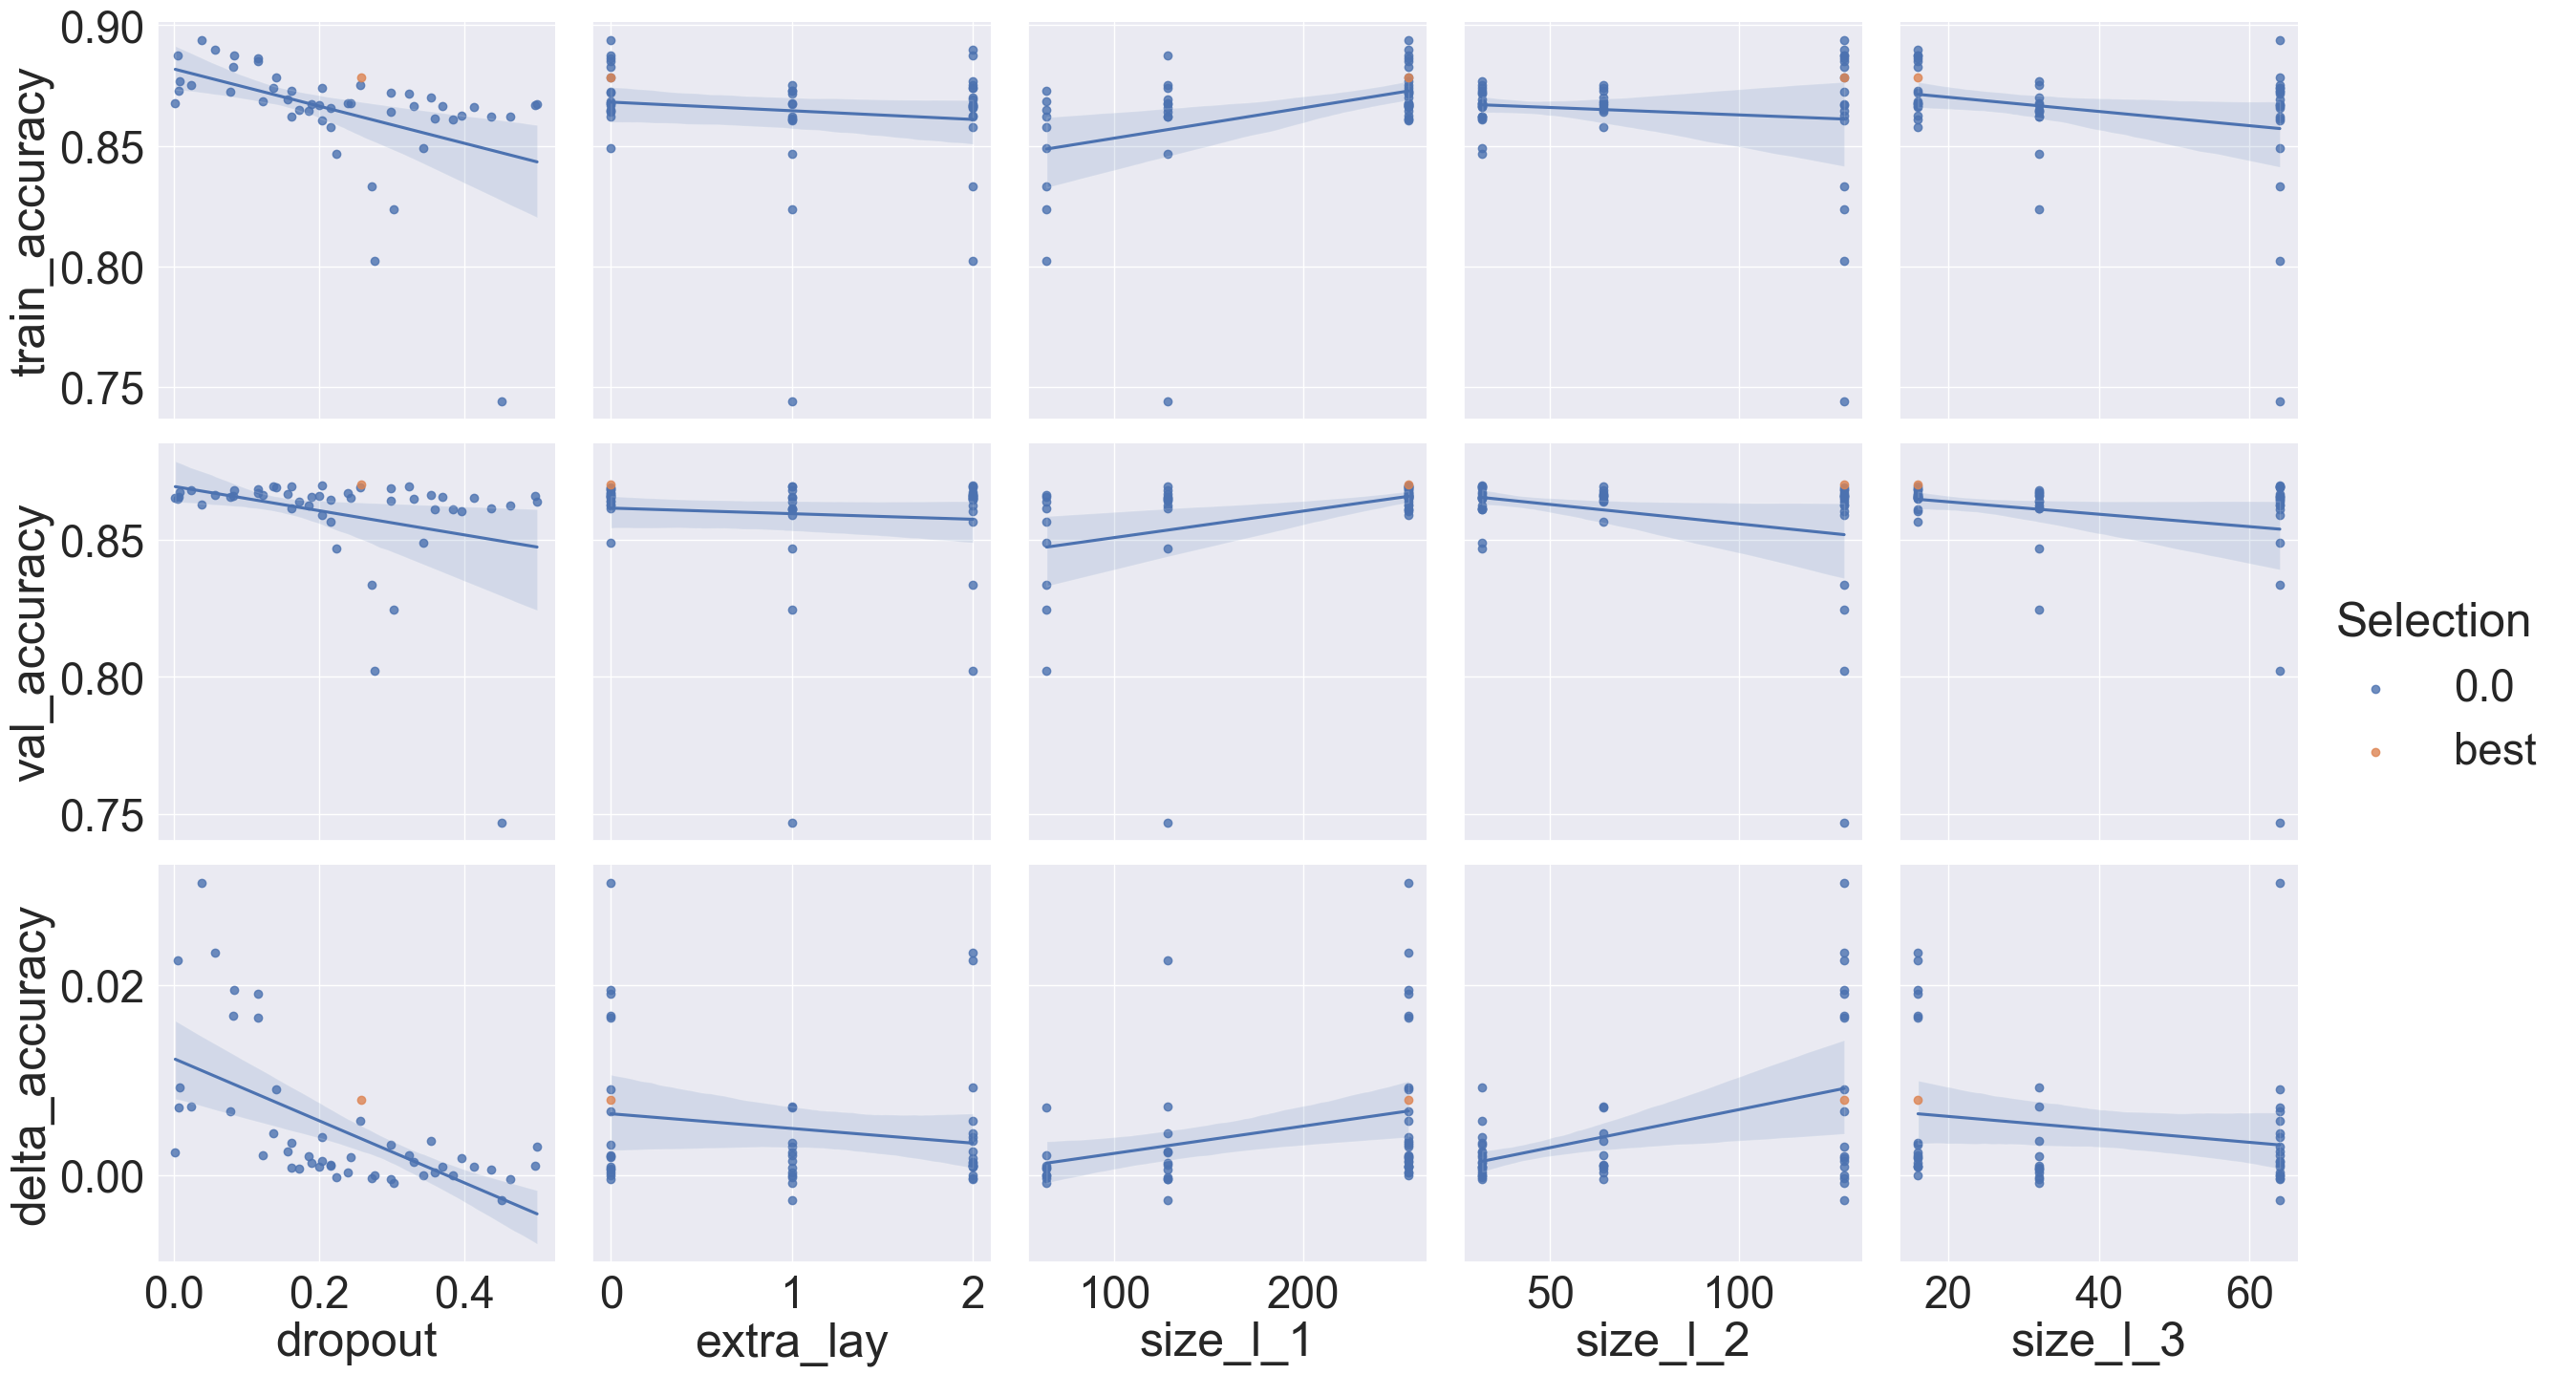

In [122]:
sns.set(font_scale = 3)
plot = sns.pairplot(trial_res, x_vars=['dropout','extra_lay','size_l_1','size_l_2','size_l_3'], y_vars=list(trial_res)[10:13], kind='reg',  height=5, hue = 'Selection')
#plot.axes[0][3].set_xticklabels([32, 64, 128],[32, 64, 128] )
#plot.axes[0][3].tick_params([32, 64, 128])

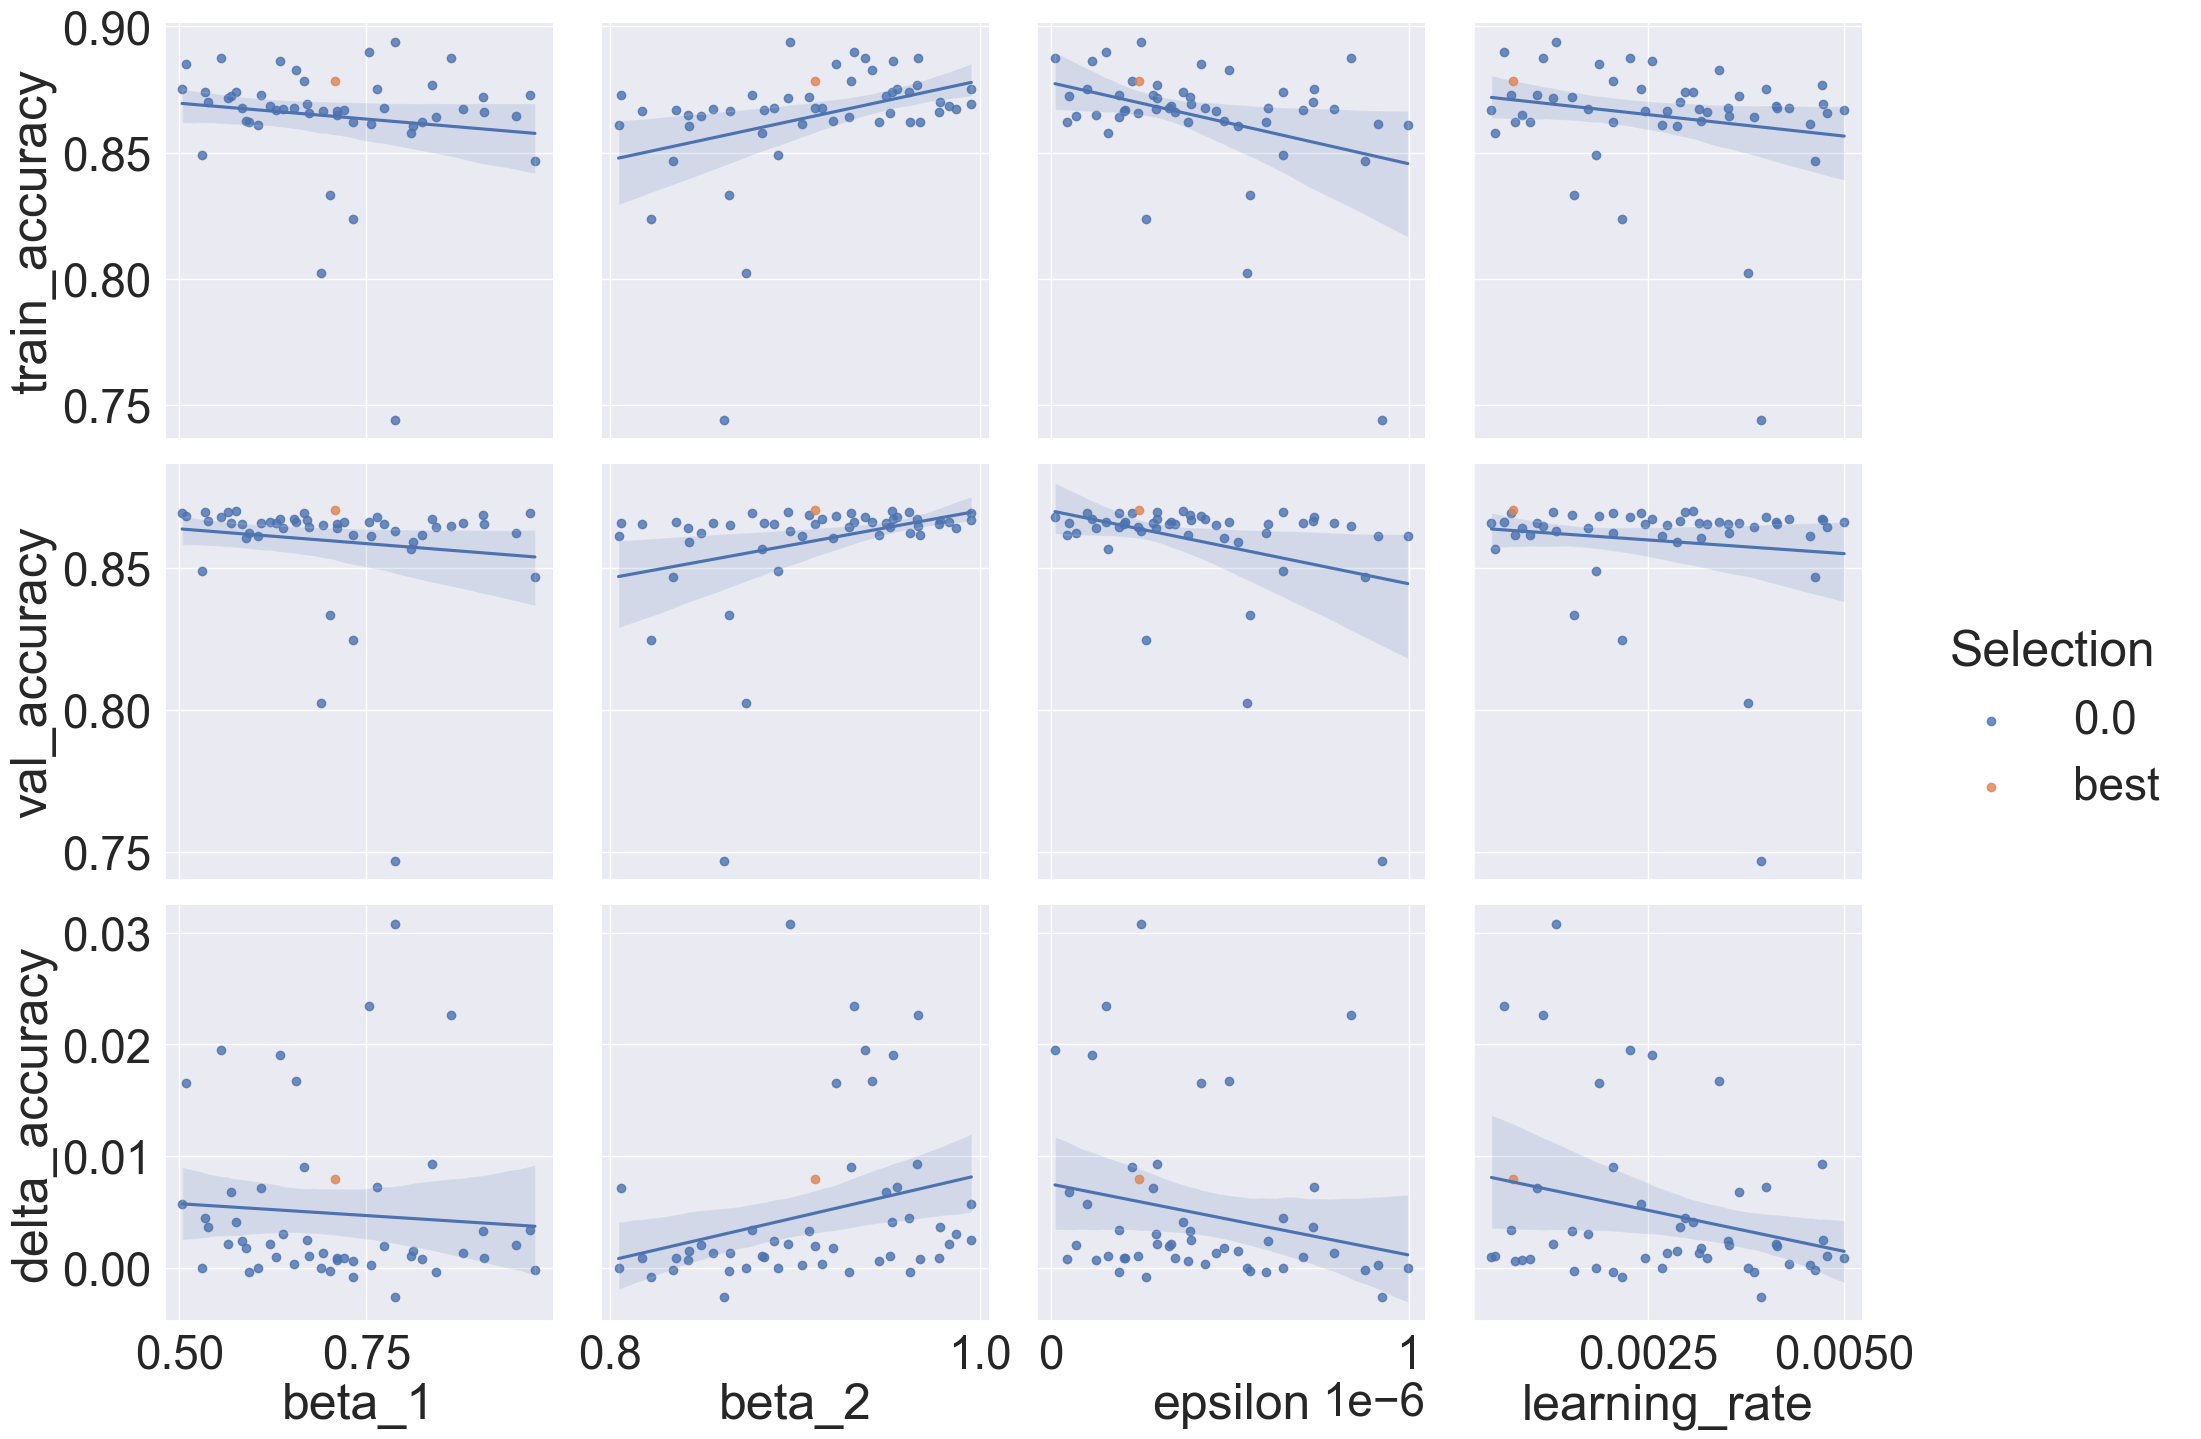

In [123]:
sns.set(font_scale = 3)
sns.pairplot(trial_res, x_vars=['beta_1', 'beta_2', 'epsilon', 'learning_rate',], y_vars=list(trial_res)[10:13], kind='reg',  height=5, hue = 'Selection')

In [ ]:
best = {'beta_1': 0.6012115429597784,
 'beta_2': 0.8342016359854416,
 'dropout': 0.00956185724776542,
 'ema_momentum': 0.9425072341735632,
 'epsilon': 1.5092638258743137e-07,
 'learning_rate': 0.001234077866108187}

In [125]:
best_hyperparams

{'beta_1': 0.7073819473423003,
 'beta_2': 0.910702505915196,
 'dropout': 0.2571921691670181,
 'ema_momentum': 0.9535824872086658,
 'epsilon': 2.4608647913095615e-07,
 'extra_lay': 0,
 'learning_rate': 0.0007822716383925304,
 'size_l_1': 2,
 'size_l_2': 2,
 'size_l_3': 0}

In [126]:
optimizer = Adam(learning_rate=best_hyperparams['learning_rate'],
                 beta_1=best_hyperparams['beta_1'], beta_2=best_hyperparams['beta_2'],
                 epsilon=best_hyperparams['epsilon'])
            
model = Sequential()

model.add(Dense([64,128,256][best_hyperparams['size_l_1']], activation='relu', input_dim=25))
model.add(Dropout(best_hyperparams['dropout']))
model.add(Dense([32,64,128][best_hyperparams['size_l_2']], activation='relu'))
model.add(Dense([16,32,64][best_hyperparams['size_l_3']], activation='relu'))


if best_hyperparams['extra_lay'] == 1:
    model.add(Dense(16, activation='relu'))
elif best_hyperparams['extra_lay'] == 2:
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=200,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0,
            )

In [ ]:
NN_model = Sequential([
            Dense(128, activation='relu', input_dim=25),
                Dropout(0.3),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])

optimizer = Adam()
NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history_basic = NN_model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=200,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0,
            )

In [80]:
X_test

,lep_pt_2,met_et,lep_pt_1,jet_n,lep_eta_0,lep_E_1,jet_pt_0,jet_pt_1,lep_eta_1,lep_pt_0,...,lep_phi_1,lep_E_0,lep_phi_0,jet_eta_1,jet_pt_2,lep_pt_3,jet_E_0,lep_charge_1,lep_charge_0,jet_E_1
135361,0.897445,0.071710,0.532603,0.412913,0.654046,0.532229,0.417121,0.000000,0.839491,0.044013,...,0.046122,0.029439,0.010515,0.504505,0.000000,0.000000,0.596845,0.000000,0.0,0.000000
8498,0.867805,0.018023,0.563507,0.000000,0.473204,0.488609,0.000000,0.000000,0.245360,0.379372,...,0.210766,0.133491,0.176315,0.504505,0.000000,0.000000,0.000000,1.000000,1.0,0.000000
494716,0.000000,0.871313,0.000000,0.900901,0.393876,0.000000,0.911386,0.951121,0.497497,0.100657,...,0.498999,0.031779,0.989617,0.228616,0.961079,0.000000,0.732871,0.496997,0.0,0.844427
240078,0.000000,0.563781,0.518952,0.000000,0.248799,0.582053,0.227753,0.000000,0.120631,0.795240,...,0.772744,0.644427,0.558750,0.504505,0.000000,0.000000,0.399913,1.000000,0.0,0.000000
79601,0.806490,0.375806,0.822674,0.000000,0.685199,0.974598,0.000000,0.000000,0.976459,0.219651,...,0.730148,0.131487,0.963619,0.504505,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456773,0.000000,0.909245,0.898769,0.900901,0.727009,0.706683,0.481992,0.687662,0.320566,0.964418,...,0.677605,0.893870,0.051692,0.104597,0.838532,0.000000,0.405562,0.000000,1.0,0.683373
372905,0.000000,0.667225,0.000000,0.655155,0.187029,0.000000,0.782431,0.596399,0.497497,0.005958,...,0.498999,0.148377,0.761780,0.038614,0.764867,0.000000,0.625968,0.496997,1.0,0.757108
98578,0.000000,0.033467,0.402567,0.000000,0.306276,0.401203,0.000000,0.000000,0.179271,0.040631,...,0.739741,0.043700,0.750706,0.504505,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
74139,0.938457,0.160209,0.660832,0.000000,0.412228,0.682955,0.000000,0.000000,0.860204,0.588247,...,0.840258,0.286298,0.292520,0.504505,0.000000,0.966752,0.000000,1.000000,0.0,0.000000


In [99]:
test = model.predict(X_test)

3255/3255 [==============================] - 1s 276us/step


In [100]:
accuracy_score(np.argmax(test, axis=1), np.argmax(y_test, axis=1))

0.8630606581461672

In [115]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [108]:
history.history['accuracy']

[0.6303697228431702,
 0.740700900554657,
 0.7446282505989075,
 0.7458573579788208,
 0.7474353909492493,
 0.74828040599823,
 0.7483987808227539,
 0.7477554678916931,
 0.7483828067779541,
 0.7492246031761169,
 0.7487061023712158,
 0.749528706073761,
 0.749634325504303,
 0.7487956881523132,
 0.7495094537734985,
 0.7492630481719971,
 0.7498775720596313,
 0.7490101456642151,
 0.7500535845756531,
 0.7493558526039124,
 0.7494006752967834,
 0.7498807907104492,
 0.7493942379951477,
 0.7499319911003113,
 0.7499607801437378,
 0.7495670914649963,
 0.7499095797538757,
 0.7494326829910278,
 0.7497623562812805,
 0.7500184178352356,
 0.7498199343681335,
 0.7496151328086853,
 0.7495542764663696,
 0.7500696182250977,
 0.7500792145729065,
 0.7502488493919373,
 0.7498615384101868,
 0.7503737211227417,
 0.750002384185791,
 0.7491893768310547,
 0.7498935461044312,
 0.7495222687721252,
 0.7499255537986755,
 0.7495383024215698,
 0.7502712607383728,
 0.7499191761016846,
 0.7493558526039124,
 0.749944806098938,

In [74]:
np.argmax(test, axis=1)

array([1, 1, 1, ..., 1, 1, 1])

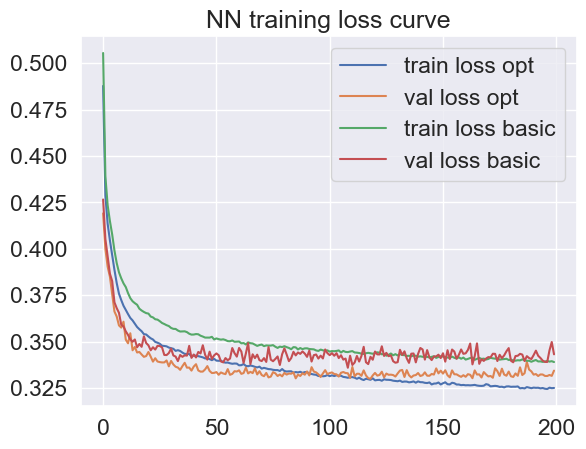

In [127]:
sns.set(font_scale = 1.5)
plt.plot(history.history['loss'],label = 'train loss opt')
plt.plot(history.history['val_loss'],label = 'val loss opt')
plt.plot(history_basic.history['loss'],label = 'train loss basic')
plt.plot(history_basic.history['val_loss'],label = 'val loss basic')
plt.title('NN training loss curve')
plt.legend()
#plt.ylim(0,2)

In [117]:
[1,2,3][2]

3

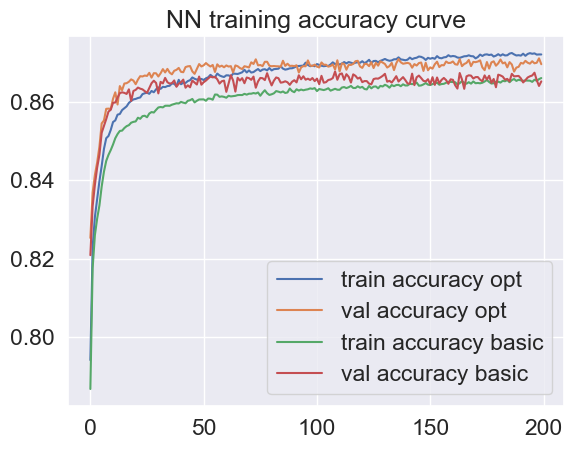

In [130]:
sns.set(font_scale = 1.5)
plt.plot(history.history['accuracy'],label = 'train accuracy opt')
plt.plot(history.history['val_accuracy'],label = 'val accuracy opt')
plt.plot(history_basic.history['accuracy'],label = 'train accuracy basic')
plt.plot(history_basic.history['val_accuracy'],label = 'val accuracy basic')
plt.title('NN training accuracy curve')
plt.legend()

In [129]:
from sklearn.metrics import confusion_matrix

In [132]:
pred_val = model.predict(X_val)

3255/3255 [==============================] - 2s 607us/step


In [136]:
cm = confusion_matrix(np.argmax(y_val, axis =1), np.argmax(pred_val, axis = 1 ))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = ['0','1','2'], 
                     columns = ['0','1','2'])

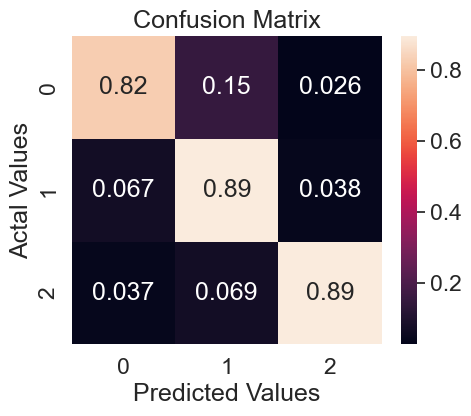

In [137]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

3255/3255 [==============================] - 1s 231us/step


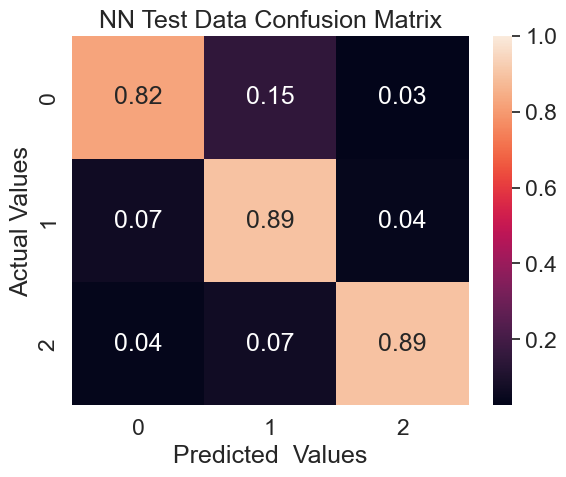

In [148]:
pred_val = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis =1), np.argmax(pred_val, axis = 1 ))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = ['0','1','2'], 
                     columns = ['0','1','2'])
fig, ax = plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=list(cm_df), yticklabels=list(cm_df), vmax=1 )
plt.title('NN Test Data Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted  Values')
plt.show(block=False)

9764/9764 [==============================] - 2s 232us/step


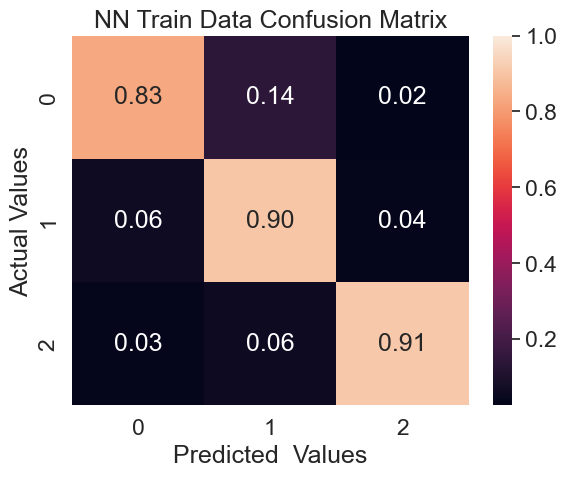

In [147]:
pred_train = model.predict(X_train)
cm = confusion_matrix(np.argmax(y_train, axis =1), np.argmax(pred_train, axis = 1 ))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = ['0','1','2'], 
                     columns = ['0','1','2'])
fig, ax = plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=list(cm_df), yticklabels=list(cm_df), vmax=1 )
plt.title('NN Train Data Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted  Values')
plt.show(block=False)

In [153]:
    from sklearn.metrics import classification_report

    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(np.argmax(y_val, axis =1), np.argmax(pred_val, axis = 1 ) ,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.90      0.82      0.86     39921
     class 1       0.82      0.89      0.86     40040
     class 2       0.89      0.89      0.89     24181

    accuracy                           0.87    104142
   macro avg       0.87      0.87      0.87    104142
weighted avg       0.87      0.87      0.87    104142



In [ ]:
bins = [-0.25, 0.75, 1.75, 2.75] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_test[y_test==label]
    pred_label = y_pred[y_test==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label ' + str(label), align = 'mid', width = 0.5, color = 'green')
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label ' + str(label), align = 'mid', width = 0.5, color = 'red')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f'Data with true label {i}, Accuracy:{accuracy_score(test_label, pred_label):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i].set_xticks(range(3))

In [ ]:
y_pred = NN_model.predict(X_val)
y_pred_train = NN_model.predict(X_train)

In [ ]:
X_test.shape

In [ ]:
y_pred[0]

In [ ]:
for i in range(y_pred.shape[0]):
    n = np.argmax(y_pred[i])
    y_pred[i] = [0,0,0]
    y_pred[i][n] = 1


In [ ]:
for i in range(y_pred_train.shape[0]):
    n = np.argmax(y_pred_train[i])
    y_pred_train[i] = [0,0,0]
    y_pred_train[i][n] = 1

In [ ]:
y_pred = np.argmax(y_pred,axis=1)
y_pred_train = np.argmax(y_pred_train,axis=1)
y_train = np.argmax(y_train, axis =1)
y_val = np.argmax(y_val, axis =1)

In [ ]:
y_train = np.argmax(y_train, axis =1)
y_val = np.argmax(y_val, axis =1)

In [ ]:
y_train = np.argmax(y_train, axis =1)

In [ ]:
y_val = np.argmax(y_val, axis =1)

In [ ]:
y_pred_train.shape

In [ ]:
y_train[y_train==0].shape

In [ ]:
y_pred_train.shape

In [ ]:
y_val.shape

In [ ]:
bins = [-0.3, 0.7, 1.7, 2.7] 
bins2 = [0, 1, 2, 3] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    
    test_label_t = y_train[y_train==label]
    pred_label_t = y_pred_train[y_train==label]
    true_label_t = pred_label_t[pred_label_t == test_label_t]
    false_label_t= pred_label_t[pred_label_t != test_label_t]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label val ' + str(label), align = 'mid', width = 0.3, color = 'green')
    ax[i].hist(true_label_t[0:int(round(len(true_label_t)/3,0))] , bins = bins2, histtype = 'barstacked', alpha=0.5, label='True Label train ' + str(label), align = 'mid', width = 0.3, color = 'blue') 
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label val ' + str(label), align = 'mid', width = 0.3, color = 'red')
    ax[i].hist(false_label_t[0:int(round(len(false_label_t)/3,0))], bins = bins2, histtype = 'barstacked', alpha=0.5, label='False Label train ' + str(label), align = 'mid', width = 0.3, color = 'orange')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f' NN, Data with true label {i},Val Accuracy:{accuracy_score(test_label, pred_label):.3f},Train Accuracy:{accuracy_score(test_label_t, pred_label_t):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count normalised to validation')
    ax[i].legend()
    ax[i].set_xticks(range(3))